# Amazon Fine Food Reviews Sentiment Analysis with Recurrent Neural Network

In [1]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"resmireghukumar","key":"ae277d6828d6e87a2cec4352b9bb68ab"}'}

In [2]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

kaggle.json


In [3]:
!kaggle datasets download -d snap/amazon-fine-food-reviews

 90% 219M/242M [00:01<00:00, 127MB/s]
100% 242M/242M [00:01<00:00, 133MB/s]


In [4]:
!mkdir amazonfood

In [5]:
!ls

amazon-fine-food-reviews.zip  amazonfood  kaggle.json  sample_data


In [6]:
!unzip amazon-fine-food-reviews.zip -d amazonfood

Archive:  amazon-fine-food-reviews.zip
  inflating: amazonfood/Reviews.csv  
  inflating: amazonfood/database.sqlite  
  inflating: amazonfood/hashes.txt   


In [7]:
#The dataset is copied to a directory named /amazonfood
!ls amazonfood/

database.sqlite  hashes.txt  Reviews.csv


In [8]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import tensorflow as tf
from string import punctuation
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.metrics import roc_curve, auc, classification_report
import gc

sns.set(color_codes=True)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [9]:
gc.collect()

30

In [10]:
data = pd.read_csv('/content/amazonfood/Reviews.csv')

In [11]:
data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [12]:
print("Number of reviews:",len(data))

Number of reviews: 568454


The dataset contains 568,454 food reviews Amazon users left from October 1999 to October 2012.

### Sentiment Score

Distribution of the score:

Text(0.5, 1.0, 'Score Distribution')

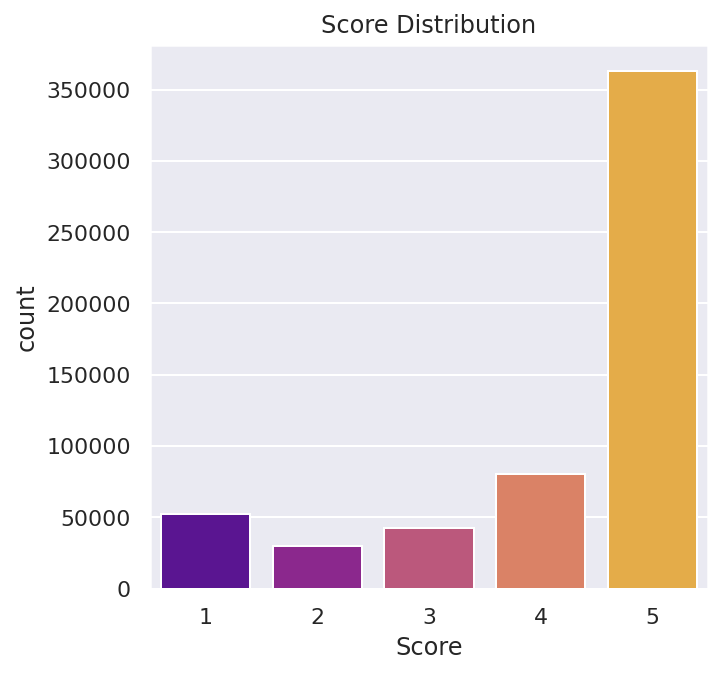

In [13]:
sns.countplot(data['Score'], palette="plasma")
fig = plt.gcf()
fig.set_size_inches(5,5)
plt.title('Score Distribution')


In [14]:
data['Score'].value_counts()

5    363122
4     80655
1     52268
3     42640
2     29769
Name: Score, dtype: int64

In [15]:
print("Average Score: ",np.mean(data.Score))
print("Median Score: ",np.median(data.Score))

Average Score:  4.183198640523243
Median Score:  5.0


As we can observe, the majority of Scores are equal to 4 and 5, and with an average score of 4.18. Because of the distribution is very skewed to the left, we will make a binary prediction. We can consider a negative review will have a Score between 1 and 3, and a positive review will have a Score equal to 4 or 5.

In [16]:
data.loc[data.Score>3,'Sentiment']="POSITIVE"
data.loc[data.Score<=3,'Sentiment']="NEGATIVE"

In [17]:
for col in data.columns: 
    print(col) 

Id
ProductId
UserId
ProfileName
HelpfulnessNumerator
HelpfulnessDenominator
Score
Time
Summary
Text
Sentiment


After creating a new variable named Sentiment that is set to NEGATIVE when the Score is between 1 and 3, and POSITIVE when the Score is equal to 4 or 5, we get this new distribution:

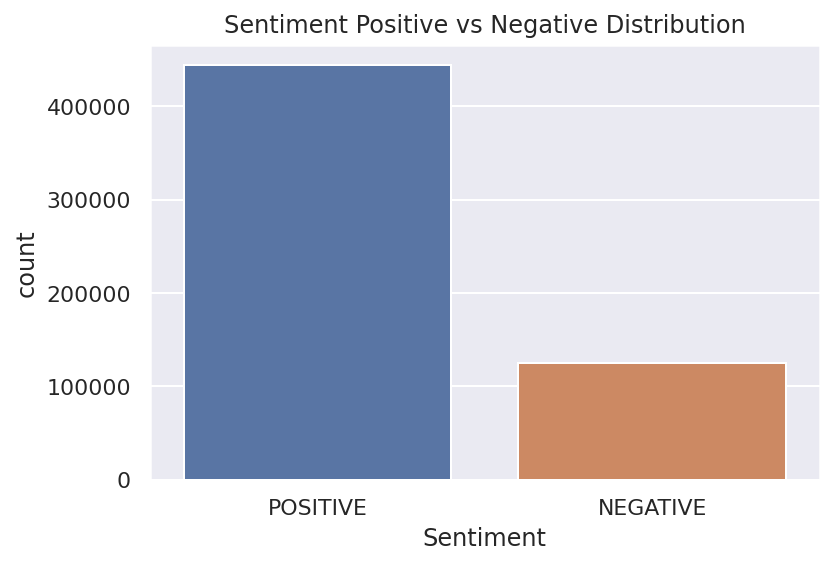

In [18]:
ax = plt.axes()
sns.countplot(data.Sentiment,ax=ax)
ax.set_title('Sentiment Positive vs Negative Distribution')
plt.show()

As we only need the Text field as an input for our model and the Sentiment (positive or negative) as an ouput, we will store this information in a reviews and sentiment variables.

In [19]:
reviews = data.Text.values
labels = data.Sentiment.values


In [20]:
labels

array(['POSITIVE', 'NEGATIVE', 'POSITIVE', ..., 'POSITIVE', 'POSITIVE',
       'POSITIVE'], dtype=object)

In [21]:
data['labels']=labels

### Text Reviews

Now let's explore our input variable "text" which contains the review of the product.

In [22]:
def print_review_and_label(i):
    if data.Sentiment[i]=="POSITIVE":
        print("POSITIVE" + "\t" + reviews[i][:90] + "...")
    else:
        print("NEGATIVE" + "\t " + reviews[i][:90] + "...")

In [23]:
print_review_and_label(39)
print_review_and_label(11)
print_review_and_label(40)
print_review_and_label(50)

POSITIVE	I ordered this for my wife as it was reccomended by our daughter.  She has this almost eve...
POSITIVE	One of my boys needed to lose some weight and the other didn't.  I put this food on the fl...
POSITIVE	The variety packs taste great!<br /><br />I have them every morning. At $0.30 cents per me...
NEGATIVE	 This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go....


The input variable is an unstructured text. By just looking at the first 90 characters, we can quickly have an idea of whether the review is positive or negative. For the negative reviews, we have negative expressions such as "not good", or "don't like it." These negative expressions can also be more nuanced depending on the context, such as "were actually small sized." For positive reviews, users use positive expression such as "Great taffy", "great price", "wide assortment", "yummy taffy", "very enjoyable," etc.

It's important to note that the text is unstructured, and we will have to do some pre-processing to remove punctuations, transform upper-case to lower case, etc.

## Data Preprocessing

In order to train our model, we had to transform the reviews into the right format. We performed the following steps:


In [24]:
reviews = data.Text.values
labels = np.array([1 if s=="POSITIVE" else 0 for s in data.Sentiment.values])

In [25]:
data['labels']=labels

First we need to remove punctuations and transform all the characters into a list of integers.

In [26]:
reviews_cleaned = []
for i in range(len(reviews)):
    reviews_cleaned.append(''.join([c.lower() for c in reviews[i] if c not in punctuation]))

In [27]:
print("Before: ",reviews[0])
print("")
print("After: ",reviews_cleaned[0])

Before:  I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.

After:  i have bought several of the vitality canned dog food products and have found them all to be of good quality the product looks more like a stew than a processed meat and it smells better my labrador is finicky and she appreciates this product better than  most


In [28]:
data['reviews_cleaned']=reviews_cleaned

In [29]:
data['reviews_cleaned'].head()

0    i have bought several of the vitality canned d...
1    product arrived labeled as jumbo salted peanut...
2    this is a confection that has been around a fe...
3    if you are looking for the secret ingredient i...
4    great taffy at a great price  there was a wide...
Name: reviews_cleaned, dtype: object

In [30]:
X, y = (data['reviews_cleaned'].values, data['labels'].values)

In [31]:
tk = Tokenizer(lower = True)
tk.fit_on_texts(X)
X_seq = tk.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, maxlen=200, padding='post')

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size = 0.25,random_state = 1)


In [33]:
batch_size = 64
X_train1 = X_train[batch_size:]
y_train1 = y_train[batch_size:]
X_valid = X_train[:batch_size]
y_valid = y_train[:batch_size]

In [34]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
vocabulary_size = len(tk.word_counts.keys())+1
max_words = 200
embedding_size = 32
model = Sequential()
model.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))
model.add(LSTM(200))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [35]:
model.fit(X_train1,y_train1,validation_data=(X_valid,y_valid),batch_size=batch_size,epochs=10)

Epoch 1/10
6661/6661 [==============================] - 554s 83ms/step - loss: 0.5161 - accuracy: 0.7828 - val_loss: 0.5270 - val_accuracy: 0.7812
Epoch 2/10
6661/6661 [==============================] - 559s 84ms/step - loss: 0.2572 - accuracy: 0.8948 - val_loss: 0.3104 - val_accuracy: 0.8906
Epoch 3/10
6661/6661 [==============================] - 563s 85ms/step - loss: 0.1571 - accuracy: 0.9403 - val_loss: 0.2837 - val_accuracy: 0.8906
Epoch 4/10
6661/6661 [==============================] - 565s 85ms/step - loss: 0.1189 - accuracy: 0.9561 - val_loss: 0.2891 - val_accuracy: 0.8906
Epoch 5/10
6661/6661 [==============================] - 560s 84ms/step - loss: 0.0901 - accuracy: 0.9681 - val_loss: 0.3034 - val_accuracy: 0.9062
Epoch 6/10
6661/6661 [==============================] - 552s 83ms/step - loss: 0.0678 - accuracy: 0.9762 - val_loss: 0.3328 - val_accuracy: 0.9062
Epoch 7/10
6661/6661 [==============================] - 551s 83ms/step - loss: 0.0511 - accuracy: 0.9825 - val_loss: 0

In [36]:
scores=model.evaluate(X_test,y_test,verbose=0)
print("Test Accuracy",scores[1])

Test Accuracy 0.9344751238822937
